In [0]:
import numpy as np 
import scipy.misc # to visualize only  
import pandas as pd
import matplotlib.pyplot as plt
import string

##############################
# Trash for loading the dataset - RUN THIS WHEN LOADING DATA BEFORE SUBMITTING
from google.colab import auth
auth.authenticate_user()
# Download the file.
!gsutil cp gs://ml_datasets/train_x.csv /tmp/train_x.csv
!gsutil cp gs://ml_datasets/train_y.csv /tmp/train_y.csv
!gsutil cp gs://ml_datasets/test_x.csv /tmp/test_x.csv

np_x_train = np.loadtxt('/tmp/train_x.csv', delimiter=",")
np_y_train = np.loadtxt('/tmp/train_y.csv', delimiter=",")
np_x_test = np.loadtxt('/tmp/test_x.csv', delimiter=",")
# Print the result to make sure the transfer worked.
# !cat /tmp/train_y.csv
##############################

print("Files successfully imported")

Copying gs://ml_datasets/train_x.csv...
\
Operation completed over 1 objects/2.0 GiB.                                      
Copying gs://ml_datasets/train_y.csv...
/ [1 files][ 97.7 KiB/ 97.7 KiB]                                                
Operation completed over 1 objects/97.7 KiB.                                     
Copying gs://ml_datasets/test_x.csv...
| [1 files][411.5 MiB/411.5 MiB]                                                
Operation completed over 1 objects/411.5 MiB.                                    
Files successfully imported


In [0]:
# DATA PREPROCESSING 
##########################################################
x = np_x_train
y = np_y_train
test = np_x_test
x = x.reshape(-1, 64, 64)
test = test.reshape(-1, 64, 64)
y = y.reshape(-1, 1) 
x = np.int64(x)
y = np.int64(y)
test = np.int64(x)

def preprocess(src_image):
    connectivity = 4
    offset = 0
    img = src_image.astype(np.uint8)
    ret,thresh = cv2.threshold(img,250,255,cv2.THRESH_BINARY)
    #ret is set to 250, it is the threshold number
    output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
    n_components = output[0] - 1
    stats = output[2][1:]
    largest_component = np.array([])
    largest_area = 0
    largest_length = 0
    largest_height = 0
    for i in range(n_components):
        
        leftmost = stats[i][0]
        topmost = stats[i][1]
        length = stats[i][2]
        height = stats[i][3]
        #area = length * height #for rectangle bounding box
        area = max(length,height) ** 2 # for square bounding box
        if(area > largest_area):
            largest_area = area
            largest_length = length
            largest_height = height
            largest_component = thresh[topmost:height+topmost, leftmost:leftmost+length]
    
    result = np.zeros([64,64],dtype=np.uint8)
    result[offset:largest_height+offset,offset:largest_length+offset] = result[offset:largest_height+offset,offset:largest_length+offset] + largest_component
    
    return result

for i in range(x.shape[0]):
  x[i] = preprocess(x[i])

for j in range(test.shape[0]):
  test[j] = preprocess(test[j])

##########################################################

Training loss after epoch  0 :  1.5153138325267261
Training accuracy:  0.52912
Validation Loss after epoch  0 :  1.5063754810123342
Validation accuracy:  0.53784
Training loss after epoch  1 :  1.334412144230538
Training accuracy:  0.58632
Validation Loss after epoch  1 :  1.3271779051188313
Validation accuracy:  0.58824
Training loss after epoch  2 :  1.2260589323842657
Training accuracy:  0.6242133333333333
Validation Loss after epoch  2 :  1.2221699138432403
Validation accuracy:  0.62496
Training loss after epoch  3 :  1.1353494198876373
Training accuracy:  0.6534133333333333
Validation Loss after epoch  3 :  1.13635131359331
Validation accuracy:  0.65624
Training loss after epoch  4 :  1.0572420725898535
Training accuracy:  0.6832533333333334
Validation Loss after epoch  4 :  1.0640101027348752
Validation accuracy:  0.682
Training loss after epoch  5 :  0.9906644401954522
Training accuracy:  0.70464
Validation Loss after epoch  5 :  1.0032926230188486
Validation accuracy:  0.70408


Training loss after epoch  17 :  0.663788638572535
Training accuracy:  0.8066933333333334
Validation Loss after epoch  17 :  0.7288168996462825
Validation accuracy:  0.7848
Training loss after epoch  18 :  0.6522880538816496
Training accuracy:  0.8096533333333333
Validation Loss after epoch  18 :  0.7213215384590032
Validation accuracy:  0.78664
Training loss after epoch  19 :  0.6416112224086314
Training accuracy:  0.8126933333333334
Validation Loss after epoch  19 :  0.71462926819446
Validation accuracy:  0.7884


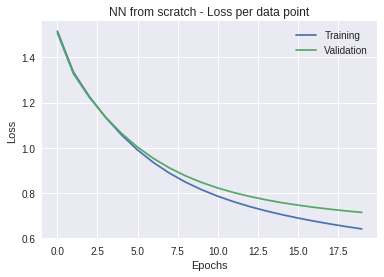

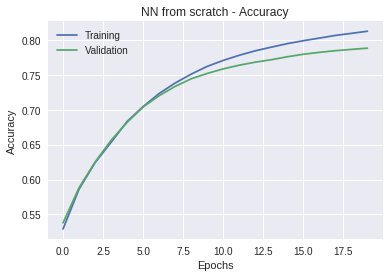

In [0]:
# The code that should run in the main notebook, but does not...

import math
import random
from sklearn.model_selection import train_test_split
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))
  
def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def leaky_relu_derivative(x):
    x[x <= 0] = 0.01
    x[x > 0] = 1
    return x

# This function predicts the classes based on data 'x' and model 'model' 
def predict(model, x, activation):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = x.dot(W1) + b1
    if activation == 'tanh':
      a1 = np.tanh(z1)
    elif activation == 'sigmoid':
      a1 = sigmoid(z1)
    elif activation == 'relu':
      a1 = np.maximum(z1,0)
    else:
      a1 = np.maximum(z1*0.01, z1)
    z2 = a1.dot(W2) + b2
    exp_result = np.exp(z2)
    probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True)
    
    # Returns the class with highest probability
    return np.argmax(probabilities, axis=1)
  
# This function calculates the loss per datapoint based on data 'x', target 'y', and model 'model'
def calculate_loss(model, x, y, activation):
    nn_num_examples = x.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation 
    z1 = x.dot(W1) + b1
    if activation == 'tanh':
      a1 = np.tanh(z1)
    elif activation == 'sigmoid':
      a1 = sigmoid(z1)
    elif activation == 'relu':
      a1 = np.maximum(z1,0)
    else:
      a1 = np.maximum(z1*0.01, z1)
    z2 = a1.dot(W2) + b2
    exp_result = np.exp(z2)
    probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True)
    
    # Calculating the loss (cross-entropy loss)
    corect_log_probs = -np.log(probabilities[range(nn_num_examples), y.astype(int)]) #this calculates: y_true*log(probabilities)
    data_loss = np.sum(corect_log_probs)
    return 1./nn_num_examples * data_loss
  
# This function fits a model to training data 'x_train' and target 'y_train'
# nn_hidden_dim: number of neurons in hidden layer
# nn_num_epoch: number of epochs
# nn_batch_size: number of datapoints in a batch used for batch stochastic gradient descent
# nn_step_size: step size of gradient descent
# nn_print_results: if true, prints after each epoch: loss on training set, accuracy on training set, accuracy on validation set
def fit_model(x_train, y_train, x_valid, y_valid, nn_hidden_dim, nn_num_epoch, nn_batch_size, nn_step_size, nn_print_results, activation='sigmoid'):
     
    nn_input_dim = x_train.shape[1]
    nn_output_dim = len(np.unique(y))
    nn_num_examples = x_train.shape[0]
    
    # Initialize the weights and the model
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hidden_dim)/np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hidden_dim))
    W2 = np.random.randn(nn_hidden_dim, nn_output_dim)/np.sqrt(nn_hidden_dim)
    b2 = np.zeros((1, nn_output_dim))
    model = {}
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
     
    # Gradient descent: for each epoch
    for i in range(nn_num_epoch):
      
        # For each batch
        for j in range(int(nn_num_examples/nn_batch_size)):
            x_batch = x_train[j*nn_batch_size:(j+1)*nn_batch_size]
            y_batch = y_train[j*nn_batch_size:(j+1)*nn_batch_size]
        
            # Forward propagation
            z1 = x_batch.dot(W1) + b1
            if activation == 'tanh':
              a1 = np.tanh(z1)
            elif activation == 'sigmoid':
              a1 = sigmoid(z1)
            elif activation == 'relu':
              a1 = np.maximum(z1,0)
            else:
              a1 = np.maximum(z1*0.01, z1)
            z2 = a1.dot(W2) + b2
            exp_result = np.exp(z2)
            probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True) #softmax
 
            # Backpropagation
            delta3 = probabilities
            delta3[range(nn_batch_size), y_batch.astype(int)] -= 1 #this calculates: probabilities - y_true 
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            if activation == 'tanh':
              delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
            elif activation == 'sigmoid':
              delta2 = delta3.dot(W2.T) * a1*(1-a1)
            elif activation == 'relu':
              delta2 = delta3.dot(W2.T) * relu_derivative(z1)
            else:
              delta2 = delta3.dot(W2.T) * leaky_relu_derivative(z1)
              a1 = np.maximum(x*0.01, x)
            dW1 = np.dot(x_batch.T, delta2)
            db1 = np.sum(delta2, axis=0)
 
            # Parameter update
            W1 += -nn_step_size * dW1
            b1 += -nn_step_size * db1
            W2 += -nn_step_size * dW2
            b2 += -nn_step_size * db2
         
        # Output model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Print results for each epoch
        if nn_print_results:
            t_loss = calculate_loss(model, x_train, y_train, activation)
            print('Training loss after epoch ', i, ': ', t_loss)
            train_loss.append(t_loss)
            y_train_pred = predict(model, x_train, activation)
            t_acc = accuracy_score(y_train, y_train_pred)
            print('Training accuracy: ', t_acc)
            train_accuracy.append(t_acc)
            v_loss = calculate_loss(model, x_valid, y_valid, activation)
            print('Validation Loss after epoch ', i, ': ', v_loss)
            valid_loss.append(v_loss)
            y_valid_pred = predict(model, x_valid, activation)
            v_acc = accuracy_score(y_valid, y_valid_pred)
            print('Validation accuracy: ', v_acc)
            valid_accuracy.append(v_acc)
     
    return model, train_loss, valid_loss, train_accuracy, valid_accuracy

nn_batch_size = [100, 200]
nn_hidden_layer = [5, 10, 50]
nn_stepsize = [0.01, 0.001]
nn_activations = ['sigmoid', 'tanh']
nn_epoch = 20

x_linear = x.reshape(50000, 4096)

X_train, X_test, y_train, y_test = train_test_split(x_linear, y,
                                                    train_size=0.75, test_size=0.25, shuffle = True)

for l in nn_activations:
  for i in nn_batch_size:
    for j in nn_hidden_layer:
      for k in nn_stepsize:
        print('Activation Func: ', l, ' Batch size: ', i, ' Neurons in hidden layer: ', j, ' Step size: ', k)

        model = fit_model(X_train, y_train, X_test, y_test, nn_hidden_dim=j, nn_num_epoch=nn_epoch, nn_batch_size=i, nn_step_size=k, nn_print_results=True, activation = l)
      
        print(' ')
  print('-----------------------------------------------')
  
model, train_loss, valid_loss, train_accuracy, valid_accuracy = fit_model(X_train, y_train, X_test, y_test, nn_hidden_dim=50, nn_num_epoch=20, nn_batch_size=200, nn_step_size=0.001, nn_print_results=True, activation = 'sigmoid')

epoch = [i for i in range(20)]

plt.plot(epoch, train_loss)
plt.plot(epoch, valid_loss)
plt.legend(['Training', 'Validation'])
plt.title("NN from scratch - Loss per data point")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)
plt.legend(['Training', 'Validation'])
plt.title("NN from scratch - Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [0]:
# The code that should run in the main notebook, but does not...

import math
import random
from sklearn.model_selection import train_test_split
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))
  
def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def leaky_relu_derivative(x):
    x[x <= 0] = 0.01
    x[x > 0] = 1
    return x

# This function predicts the classes based on data 'x' and model 'model' 
def predict(model, x, activation):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = x.dot(W1) + b1
    if activation == 'tanh':
      a1 = np.tanh(z1)
    elif activation == 'sigmoid':
      a1 = sigmoid(z1)
    elif activation == 'relu':
      a1 = np.maximum(z1,0)
    else:
      a1 = np.maximum(z1*0.01, z1)
    z2 = a1.dot(W2) + b2
    exp_result = np.exp(z2)
    probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True)
    
    # Returns the class with highest probability
    return np.argmax(probabilities, axis=1)
  
# This function calculates the loss per datapoint based on data 'x', target 'y', and model 'model'
def calculate_loss(model, x, y, activation):
    nn_num_examples = x.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation 
    z1 = x.dot(W1) + b1
    if activation == 'tanh':
      a1 = np.tanh(z1)
    elif activation == 'sigmoid':
      a1 = sigmoid(z1)
    elif activation == 'relu':
      a1 = np.maximum(z1,0)
    else:
      a1 = np.maximum(z1*0.01, z1)
    z2 = a1.dot(W2) + b2
    exp_result = np.exp(z2)
    probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True)
    
    # Calculating the loss (cross-entropy loss)
    corect_log_probs = -np.log(probabilities[range(nn_num_examples), y.astype(int)]) #this calculates: y_true*log(probabilities)
    data_loss = np.sum(corect_log_probs)
    return 1./nn_num_examples * data_loss
  
# This function fits a model to training data 'x_train' and target 'y_train'
# nn_hidden_dim: number of neurons in hidden layer
# nn_num_epoch: number of epochs
# nn_batch_size: number of datapoints in a batch used for batch stochastic gradient descent
# nn_step_size: step size of gradient descent
# nn_print_results: if true, prints after each epoch: loss on training set, accuracy on training set, accuracy on validation set
def fit_model(x_train, y_train, x_valid, y_valid, nn_hidden_dim, nn_num_epoch, nn_batch_size, nn_step_size, nn_print_results, activation='sigmoid'):
     
    nn_input_dim = x_train.shape[1]
    nn_output_dim = len(np.unique(y))
    nn_num_examples = x_train.shape[0]
    
    # Initialize the weights and the model
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hidden_dim)/np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hidden_dim))
    W2 = np.random.randn(nn_hidden_dim, nn_output_dim)/np.sqrt(nn_hidden_dim)
    b2 = np.zeros((1, nn_output_dim))
    model = {}
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
     
    # Gradient descent: for each epoch
    for i in range(nn_num_epoch):
      
        # For each batch
        for j in range(int(nn_num_examples/nn_batch_size)):
            x_batch = x_train[j*nn_batch_size:(j+1)*nn_batch_size]
            y_batch = y_train[j*nn_batch_size:(j+1)*nn_batch_size]
        
            # Forward propagation
            z1 = x_batch.dot(W1) + b1
            if activation == 'tanh':
              a1 = np.tanh(z1)
            elif activation == 'sigmoid':
              a1 = sigmoid(z1)
            elif activation == 'relu':
              a1 = np.maximum(z1,0)
            else:
              a1 = np.maximum(z1*0.01, z1)
            z2 = a1.dot(W2) + b2
            exp_result = np.exp(z2)
            probabilities = exp_result / np.sum(exp_result, axis=1, keepdims=True) #softmax
 
            # Backpropagation
            delta3 = probabilities
            delta3[range(nn_batch_size), y_batch.astype(int)] -= 1 #this calculates: probabilities - y_true 
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            if activation == 'tanh':
              delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
            elif activation == 'sigmoid':
              delta2 = delta3.dot(W2.T) * a1*(1-a1)
            elif activation == 'relu':
              delta2 = delta3.dot(W2.T) * relu_derivative(z1)
            else:
              delta2 = delta3.dot(W2.T) * leaky_relu_derivative(z1)
              a1 = np.maximum(x*0.01, x)
            dW1 = np.dot(x_batch.T, delta2)
            db1 = np.sum(delta2, axis=0)
 
            # Parameter update
            W1 += -nn_step_size * dW1
            b1 += -nn_step_size * db1
            W2 += -nn_step_size * dW2
            b2 += -nn_step_size * db2
         
        # Output model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Print results for each epoch
        if nn_print_results:
            t_loss = calculate_loss(model, x_train, y_train, activation)
            print('Training loss after epoch ', i, ': ', t_loss)
            train_loss.append(t_loss)
            y_train_pred = predict(model, x_train, activation)
            t_acc = accuracy_score(y_train, y_train_pred)
            print('Training accuracy: ', t_acc)
            train_accuracy.append(t_acc)
            v_loss = calculate_loss(model, x_valid, y_valid, activation)
            print('Validation Loss after epoch ', i, ': ', v_loss)
            valid_loss.append(v_loss)
            y_valid_pred = predict(model, x_valid, activation)
            v_acc = accuracy_score(y_valid, y_valid_pred)
            print('Validation accuracy: ', v_acc)
            valid_accuracy.append(v_acc)
     
    return model, train_loss, valid_loss, train_accuracy, valid_accuracy

nn_batch_size = [100, 200]
nn_hidden_layer = [5, 10, 50]
nn_stepsize = [0.01, 0.001]
nn_activations = ['sigmoid', 'tanh']
nn_epoch = 20

x_linear = x.reshape(50000, 4096)

X_train, X_test, y_train, y_test = train_test_split(x_linear, y,
                                                    train_size=0.75, test_size=0.25, shuffle = True)

for l in nn_activations:
  for i in nn_batch_size:
    for j in nn_hidden_layer:
      for k in nn_stepsize:
        print('Activation Func: ', l, ' Batch size: ', i, ' Neurons in hidden layer: ', j, ' Step size: ', k)

        model = fit_model(X_train, y_train, X_test, y_test, nn_hidden_dim=j, nn_num_epoch=nn_epoch, nn_batch_size=i, nn_step_size=k, nn_print_results=True, activation = l)
      
        print(' ')
  print('-----------------------------------------------')
  
model, train_loss, valid_loss, train_accuracy, valid_accuracy = fit_model(X_train, y_train, X_test, y_test, nn_hidden_dim=50, nn_num_epoch=20, nn_batch_size=200, nn_step_size=0.001, nn_print_results=True, activation = 'sigmoid')

epoch = [i for i in range(20)]

plt.plot(epoch, train_loss)
plt.plot(epoch, valid_loss)
plt.legend(['Training', 'Validation'])
plt.title("NN from scratch - Loss per data point")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)
plt.legend(['Training', 'Validation'])
plt.title("NN from scratch - Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()